<a href="https://colab.research.google.com/github/AritroGomes/INST414/blob/main/FIFA_2022_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --------------------------------------------------------
# FIFA 2022 Data Analysis
# Author: Aritro Gomes
# Course: INST414 / University of Maryland
# Date: 09/19/2025
# --------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)

DATA_PATH = "Fifa_world_cup_matches.csv"   # adjust if needed


In [ ]:
fifa = pd.read_csv(DATA_PATH)

print(f"Rows: {len(fifa)}, Cols: {fifa.shape[1]}")
fifa.head(3)


Rows: 64, Cols: 88


,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,date,hour,category,total attempts team1,total attempts team2,conceded team1,conceded team2,goal inside the penalty area team1,goal inside the penalty area team2,goal outside the penalty area team1,goal outside the penalty area team2,assists team1,assists team2,on target attempts team1,on target attempts team2,off target attempts team1,off target attempts team2,attempts inside the penalty area team1,attempts inside the penalty area team2,attempts outside the penalty area team1,attempts outside the penalty area team2,left channel team1,left channel team2,left inside channel team1,left inside channel team2,central channel team1,central channel team2,right inside channel team1,right inside channel team2,right channel team1,right channel team2,total offers to receive team1,total offers to receive team2,inbehind offers to receive team1,inbehind offers to receive team2,inbetween offers to receive team1,inbetween offers to receive team2,infront offers to receive team1,infront offers to receive team2,receptions between midfield and defensive lines team1,receptions between midfield and defensive lines team2,attempted line breaks team1,attempted line breaks team2,completed line breaksteam1,completed line breaks team2,attempted defensive line breaks team1,attempted defensive line breaks team2,completed defensive line breaksteam1,completed defensive line breaks team2,yellow cards team1,yellow cards team2,red cards team1,red cards team2,fouls against team1,fouls against team2,offsides team1,offsides team2,passes team1,passes team2,passes completed team1,passes completed team2,crosses team1,crosses team2,crosses completed team1,crosses completed team2,switches of play completed team1,switches of play completed team2,corners team1,corners team2,free kicks team1,free kicks team2,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2
0,QATAR,ECUADOR,42%,50%,8%,0,2,20 NOV 2022,17 : 00,Group A,5,6,2,0,0,2,0,0,0,1,0,3,5,3,2,4,3,2,15,8,0,7,3,6,1,4,9,6,520,532,116,127,235,187,169,218,5,8,136,155,86,99,9,13,4,7,4,2,0,0,15,15,3,4,450,480,381,409,9,14,4,4,9,9,1,3,19,17,0,1,6,5,0,0,52,72,256,279
1,ENGLAND,IRAN,72%,19%,9%,6,2,21 NOV 2022,14 : 00,Group B,13,8,2,6,6,2,0,0,6,1,7,3,3,4,10,6,3,2,11,3,5,0,2,3,3,1,11,0,1061,212,207,53,386,86,468,73,16,4,238,101,178,45,25,7,16,4,0,2,0,0,9,14,2,2,809,224,730,154,23,8,7,1,12,3,8,0,16,10,0,1,8,13,0,0,63,72,139,416
2,SENEGAL,NETHERLANDS,44%,45%,11%,0,2,21 NOV 2022,17 : 00,Group A,14,9,2,0,0,2,0,0,0,1,3,3,8,5,7,5,7,4,12,11,4,2,2,2,4,7,13,20,502,506,123,117,230,191,149,198,15,14,151,162,89,96,22,22,15,10,2,1,0,0,13,13,2,1,383,438,313,374,19,25,7,8,9,6,6,7,14,14,0,0,9,15,0,0,63,73,263,251


In [ ]:
# --- Cleaning: possession from '65%' -> 65.0 ---
for col in ["possession team1", "possession team2"]:
    fifa[col] = (
        fifa[col]
        .astype(str)
        .str.replace("%", "", regex=False)
        .str.strip()
        .replace({"": np.nan})
        .astype(float)
    )

# --- Create match winner/loser/draw ---
def winner_fn(row):
    g1 = row["number of goals team1"]
    g2 = row["number of goals team2"]
    if g1 > g2:
        return row["team1"]
    elif g2 > g1:
        return row["team2"]
    else:
        return "Draw"

fifa["winner"] = fifa.apply(winner_fn, axis=1)

# --- Create a tidy, per-team view (long format) ---
# this lets us compare "a team in a match" rather than the match as a whole
left = fifa[[
    "team1","team2","number of goals team1","number of goals team2",
    "possession team1","possession team2","category"
]].copy()
a = left.rename(columns={
    "team1":"team",
    "team2":"opponent",
    "number of goals team1":"goals_for",
    "number of goals team2":"goals_against",
    "possession team1":"possession"
})
b = left.rename(columns={
    "team2":"team",
    "team1":"opponent",
    "number of goals team2":"goals_for",
    "number of goals team1":"goals_against",
    "possession team2":"possession"
})

team_matches = pd.concat([a,b], ignore_index=True)

# outcome from the team’s perspective
def outcome_fn(row):
    if row["goals_for"] > row["goals_against"]:
        return "Win"
    elif row["goals_for"] < row["goals_against"]:
        return "Loss"
    else:
        return "Draw"

team_matches["outcome"] = team_matches.apply(outcome_fn, axis=1)

# final quick peek
team_matches.head(5)


,team,opponent,goals_for,goals_against,possession,possession team2,category,possession team1,outcome
0,QATAR,ECUADOR,0,2,42.0,50.0,Group A,NaN,Loss
1,ENGLAND,IRAN,6,2,72.0,19.0,Group B,NaN,Win
2,SENEGAL,NETHERLANDS,0,2,44.0,45.0,Group A,NaN,Loss
3,UNITED STATES,WALES,1,1,51.0,39.0,Group B,NaN,Draw
4,ARGENTINA,SAUDI ARABIA,1,2,64.0,24.0,Group C,NaN,Loss


In [ ]:
# --- Average possession by outcome ---
avg_pos_by_outcome = (
    team_matches
    .groupby("outcome", dropna=False)["possession"]
    .mean()
    .reindex(["Win","Draw","Loss"])
    .round(2)
)
avg_pos_by_outcome


,possession
outcome,
Win,42.71
Draw,44.13
Loss,45.41


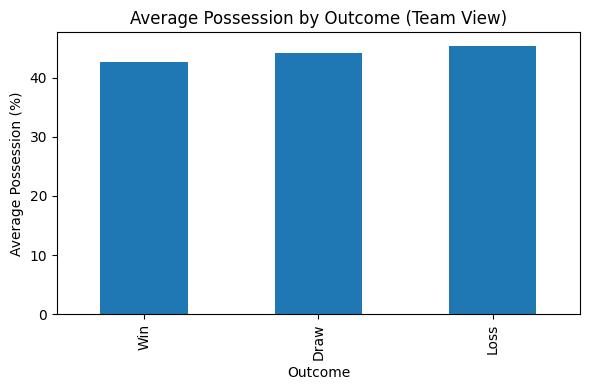

In [ ]:
# --- Simple bar chart: average possession by outcome ---
plt.figure(figsize=(6,4))
avg_pos_by_outcome.plot(kind="bar")
plt.title("Average Possession by Outcome (Team View)")
plt.xlabel("Outcome")
plt.ylabel("Average Possession (%)")
plt.tight_layout()
plt.show()


In [ ]:
# --- Did the higher-possession side win more often? ---
def higher_possession_winner(row):
    p1, p2 = row["possession team1"], row["possession team2"]
    if pd.isna(p1) or pd.isna(p2):
        return np.nan
    if p1 == p2:  # rare tie
        return "Equal"
    hp_team = row["team1"] if p1 > p2 else row["team2"]
    if row["winner"] == "Draw":
        return "Draw"
    return "HigherPossWon" if row["winner"] == hp_team else "HigherPossLost"

fifa["higher_possession_result"] = fifa.apply(higher_possession_winner, axis=1)

hp_counts = fifa["higher_possession_result"].value_counts(dropna=False)
hp_share = (hp_counts / hp_counts.sum()).round(3)
hp_counts, hp_share


(higher_possession_result
 HigherPossLost    25
 HigherPossWon     22
 Draw              14
 Equal              3
 Name: count, dtype: int64,
 higher_possession_result
 HigherPossLost    0.391
 HigherPossWon     0.344
 Draw              0.219
 Equal             0.047
 Name: count, dtype: float64)

/tmp/ipython-input-4060323676.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pos_band")["is_win"]


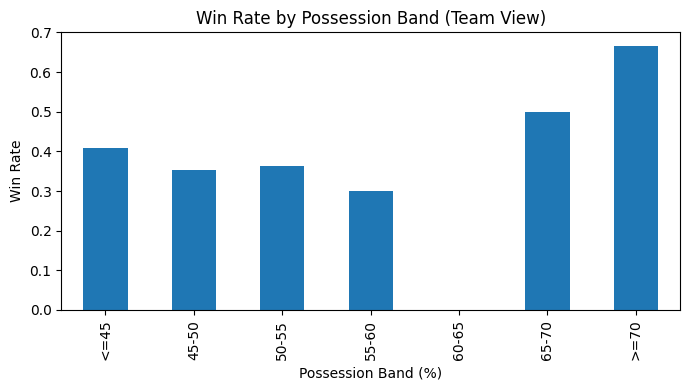

,is_win
pos_band,
<=45,0.408
45-50,0.353
50-55,0.364
55-60,0.300
60-65,0.000
65-70,0.500
>=70,0.667


In [ ]:
# --- Possession bands for teams and their win rates ---
bins = [0,45,50,55,60,65,70,100]
labels = ["<=45","45-50","50-55","55-60","60-65","65-70",">=70"]
team_matches["pos_band"] = pd.cut(team_matches["possession"], bins=bins, labels=labels, include_lowest=True)

win_rates = (
    team_matches
    .assign(is_win = (team_matches["outcome"]=="Win").astype(int))
    .groupby("pos_band")["is_win"]
    .mean()
    .round(3)
)

plt.figure(figsize=(7,4))
win_rates.plot(kind="bar")
plt.title("Win Rate by Possession Band (Team View)")
plt.xlabel("Possession Band (%)")
plt.ylabel("Win Rate")
plt.tight_layout()
plt.show()

win_rates


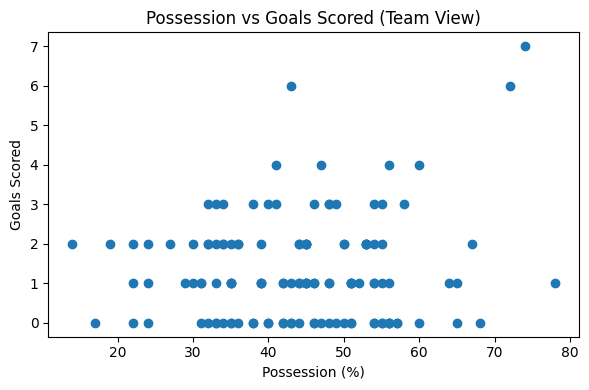

,possession,goals_for
possession,1.00,0.13
goals_for,0.13,1.00


In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(team_matches["possession"], team_matches["goals_for"])
plt.title("Possession vs Goals Scored (Team View)")
plt.xlabel("Possession (%)")
plt.ylabel("Goals Scored")
plt.tight_layout()
plt.show()

# Quick correlation (Pearson)
team_matches[["possession","goals_for"]].corr().round(3)


In [ ]:
stage_map = {
    "group": "Group",
    "Group": "Group",
    "Round of 16": "Knockout",
    "Quarter-final": "Knockout",
    "Semi-final": "Knockout",
    "Final": "Knockout",
    "Third place": "Knockout"
}
team_matches["stage_simple"] = team_matches["category"].map(stage_map).fillna("Group")

avg_pos_by_stage = (
    team_matches
    .groupby(["stage_simple","outcome"])["possession"]
    .mean()
    .round(2)
    .unstack()
)

avg_pos_by_stage


outcome,Draw,Loss,Win
stage_simple,,,
Group,44.15,44.59,43.31
Knockout,44.10,48.60,40.40


In [ ]:
# --- Save the tidy team-level data for your repo ---
team_matches.to_csv("fifa22_team_matches_tidy.csv", index=False)
